In [1]:
!pip install rdkit

In [2]:
!pip install rdkit-pypi
!pip install matplotlib

In [3]:
!pip install torch

In [4]:
!pip install torch_geometric

In [5]:
!pip install torchvision

In [6]:
!pip install pytorch-lightning

In [7]:
!pip install deepchem

In [8]:
!pip install pytorch-lightning

In [9]:
# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import rdchem
import torch
from torch_geometric.data import Data


In [10]:
import os
import csv
import glob
import torch
import numpy as np
import networkx as nx
from torch_geometric.data import Data

In [11]:
from typing import List, Tuple
import numpy as np

from deepchem.utils.typing import RDKitAtom, RDKitBond, RDKitMol
from deepchem.feat.graph_data import GraphData
from deepchem.feat.base_classes import MolecularFeaturizer
from deepchem.utils.molecule_feature_utils import one_hot_encode
from deepchem.utils.molecule_feature_utils import get_atom_type_one_hot
from deepchem.utils.molecule_feature_utils import construct_hydrogen_bonding_info
from deepchem.utils.molecule_feature_utils import get_atom_hydrogen_bonding_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_hybridization_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_total_num_Hs_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_is_in_aromatic_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_chirality_one_hot
from deepchem.utils.molecule_feature_utils import get_atom_formal_charge
from deepchem.utils.molecule_feature_utils import get_atom_partial_charge
from deepchem.utils.molecule_feature_utils import get_atom_total_degree_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_type_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_in_same_ring_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_is_conjugated_one_hot
from deepchem.utils.molecule_feature_utils import get_bond_stereo_one_hot

In [12]:
# from deepchem.utils.molecule_feature_utils import get_atom_formal_charge_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_implicit_valence_one_hot
# from deepchem.utils.molecule_feature_utils import get_atom_explicit_valence_one_hot
# from deepchem.utils.rdkit_utils import compute_all_pairs_shortest_path
# from deepchem.utils.rdkit_utils import compute_pairwise_ring_info

In [13]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [14]:
DEFAULT_ATOM_TYPE_SET = [
    "C",
    "N",
    "O",
    "F",
    "P",
    "S",
    "Cl",
    "Br",
    "I",
]
DEFAULT_HYBRIDIZATION_SET = ["SP", "SP2", "SP3"]
DEFAULT_TOTAL_NUM_Hs_SET = [0, 1, 2, 3, 4]
DEFAULT_FORMAL_CHARGE_SET = [-2, -1, 0, 1, 2]
DEFAULT_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5]
DEFAULT_RING_SIZE_SET = [3, 4, 5, 6, 7, 8]
DEFAULT_BOND_TYPE_SET = ["SINGLE", "DOUBLE", "TRIPLE", "AROMATIC"]
DEFAULT_BOND_STEREO_SET = ["STEREONONE", "STEREOANY", "STEREOZ", "STEREOE"]
DEFAULT_GRAPH_DISTANCE_SET = [1, 2, 3, 4, 5, 6, 7]
DEFAULT_ATOM_IMPLICIT_VALENCE_SET = [0, 1, 2, 3, 4, 5, 6]
DEFAULT_ATOM_EXPLICIT_VALENCE_SET = [1, 2, 3, 4, 5, 6]

USER_ATOM_TYPE_SET  = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca',
       'Fe', 'As', 'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag',
       'Pd', 'Co', 'Se', 'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni',
       'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb']
USER_TOTAL_DEGREE_SET = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
USER_HYBRIDIZATION_SET = ["SP", "SP2", "SP3", 'SP3D','SP3D2']

In [15]:
def one_hot_encode(value, allowed_values, include_unknown_set=False):
    """Create a one-hot encoded vector based on allowed values."""
    if include_unknown_set and value not in allowed_values:
        value = allowed_values[-1]

    return [1.0 if v == value else 0.0 for v in allowed_values]


In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import torch
from torch_geometric.data import Data

class MolGraphConvFeaturizer:
    def __init__(self, use_edges=True, use_chirality=True, use_partial_charge=True):
        self.use_edges = use_edges
        self.use_chirality = use_chirality
        self.use_partial_charge = use_partial_charge

    def featurize(self, smiles):
        # Convert SMILES to RDKit Mol object
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # Compute Gasteiger charges if necessary
        if self.use_partial_charge:
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                return None  # Unable to compute charges for this molecule

        # Get atom features
        atom_features = np.array([self._get_atom_features(atom) for atom in mol.GetAtoms()])

        # Get bond features and indices
        if self.use_edges:
            edge_indices, edge_features = self._get_bond_features(mol)
        else:
            edge_indices, edge_features = None, None

        # Create a graph data object
        graph = Data(x=torch.tensor(atom_features, dtype=torch.float),
                     edge_index=torch.tensor(edge_indices, dtype=torch.long).t().contiguous() if edge_indices is not None else None,
                     edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)

        return graph

    def _get_atom_features(self, atom):
        # One-hot encoding of atom type
        atom_type = one_hot_encode(atom.GetSymbol(), USER_ATOM_TYPE_SET, include_unknown_set=True)

        # Formal charge of the atom
        formal_charge = get_atom_formal_charge(atom)

        # One-hot encoding of the atom's hybridization
        hybridization = get_atom_hybridization_one_hot(atom, USER_HYBRIDIZATION_SET, include_unknown_set=True)

        # Aromaticity of the atom
        aromatic = get_atom_is_in_aromatic_one_hot(atom)

        # One-hot encoding of the atom's degree
        degree = get_atom_total_degree_one_hot(atom, USER_TOTAL_DEGREE_SET, include_unknown_set=True)

        # One-hot encoding of the total number of hydrogens connected to the atom
        total_num_Hs = get_atom_total_num_Hs_one_hot(atom, DEFAULT_TOTAL_NUM_Hs_SET, include_unknown_set=True)

        # Concatenating all the features
        atom_feat = np.concatenate([
            atom_type, formal_charge, hybridization, aromatic, degree, total_num_Hs
        ])

        if self.use_chirality:
            chirality = get_atom_chirality_one_hot(atom)
            atom_feat = np.concatenate([atom_feat, chirality])

        if self.use_partial_charge:
            partial_charge = get_atom_partial_charge(atom)
            atom_feat = np.concatenate([atom_feat, partial_charge])

        return atom_feat

    def _get_bond_features(self, mol):
        # Initialize lists for source and destination atoms of each bond
        src, dest, bond_features = [], [], []

        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            src += [start, end]
            dest += [end, start]

            # Extract bond features and duplicate for both bond directions
            bond_feat = self._extract_bond_features(bond)
            bond_features += [bond_feat, bond_feat]

        edge_indices = [src, dest]
        print("edge_indices : ",edge_indices)
        print("bond_features : ",bond_features)
        return edge_indices, bond_features
        
    def _extract_bond_features(self, bond):
        """
        Extract bond features from a RDKit bond object.
        """

        # One-hot encoding of bond type
        bond_type = one_hot_encode(bond.GetBondTypeAsDouble(), [1.0, 1.5, 2.0, 3.0], include_unknown_set=True)

        # Whether the bond is in the same ring
        same_ring = [1.0] if bond.IsInRing() else [0.0]

        # Whether the bond is conjugated
        conjugated = [1.0] if bond.GetIsConjugated() else [0.0]

        # One-hot encoding of bond stereo configuration
        stereo = one_hot_encode(bond.GetStereo(), [Chem.rdchem.BondStereo.STEREONONE, 
                                                   Chem.rdchem.BondStereo.STEREOANY, 
                                                   Chem.rdchem.BondStereo.STEREOZ, 
                                                   Chem.rdchem.BondStereo.STEREOE], 
                                include_unknown_set=True)

        # Concatenate all bond features
        bond_feat = np.concatenate([bond_type, same_ring, conjugated, stereo])

        return bond_feat        


In [17]:
# Example usage
#featurizer = MolGraphConvFeaturizer()
#graph = featurizer.featurize('CCO')  # Example SMILES string
#print(type(graph))
#print((graph))

In [18]:
## Assuming graphs[0] is a torch_geometric.data.Data object from your graphs list

## Print node features
#print("Len of graph:", len(graph))
#print("Node Features:")
#for i, node_feature in enumerate(graph.x):
#    print(f"Node {i}: {node_feature}")

## Print edge pairs and edge features
#print("\nEdge Pairs and Features:")
#for i, edge in enumerate(graph.edge_index.t()):
#    src, dest = edge[0].item(), edge[1].item()
#    edge_feature = graph.edge_attr[i]
#    print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


In [19]:
#graph.is_directed()

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

def visualize_graph(data):
    # Create a networkx graph
    G = nx.Graph()

    # Add nodes to the graph
    for i in range(data.num_nodes):
        G.add_node(i)

    # Add edges to the graph
    edge_index = data.edge_index.t().cpu().numpy()
    for edge in edge_index:
        src, dest = edge[0], edge[1]
        G.add_edge(src, dest)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Graph Visualization")
    plt.show()
#visualize_graph(graph)

In [21]:
# Load the data 
#smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-41-clean.txt", header=None, names=['SMILES'])
smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean.txt", header=None, names=['SMILES'])
smiles_df = pd.read_csv("D:\\PhD\\Chapter3\\Unsupervised_GAN_Code\\pubchem-10m-clean_test.txt", header=None, names=['SMILES'])


In [22]:
smiles_df.head(5)

,SMILES
0,CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1,CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2,COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3,OCCn1cc(CNc2cccc3c2CCCC3)nn1
4,CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...


In [23]:
# Define a function to convert a SMILES string to a graph data object
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom.GetAtomicNum())

    # Get bond features and adjacency information
    edge_indices = []
    edge_features = []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_indices += [(start, end), (end, start)]
        edge_feature = [bond.GetBondTypeAsDouble()]
        edge_features += [edge_feature, edge_feature]  # add twice for both directions

    # Convert to tensors
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create a graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


In [24]:
def read_smiles_df_check(smiles_df):
    graphs = []
    invalid_indices = []
    for idx, smiles in enumerate(smiles_df['SMILES']):
        graph = smiles_to_graph(smiles)
        if graph:
            graphs.append(graph)
        else:
            print("Invalid graph :", idx,smiles)
            invalid_indices.append(idx)
    return graphs, invalid_indices

graphs, invalid_indices = read_smiles_df_check(smiles_df)
print(f"Number of valid graphs: {len(graphs)}")
print(f"Indices of invalid SMILES: {invalid_indices}")

Number of valid graphs: 402
Indices of invalid SMILES: []


In [25]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 402


In [26]:
# Initialize the featurizer
#featurizer = MolGraphConvFeaturizer()
featurizer = MolGraphConvFeaturizer(use_edges=True, use_chirality=True, use_partial_charge=True)

# Featurize SMILES strings and track invalid entries
graphs = []
invalid_indices = []
#for idx, smiles in enumerate(smiles_df_test['SMILES']):
for idx, smiles in enumerate(smiles_df['SMILES']):
    try:
        graph = featurizer.featurize(smiles)
        graphs.append(graph)
    except Exception as e:
        print(f"Invalid SMILES at index {idx}: {smiles} (Error: {e})")
        invalid_indices.append(idx)


edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 1, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 14, 16, 16, 17, 17, 18, 18, 19, 18, 20, 20, 21, 21, 22, 22, 23, 23, 24, 7, 2, 13, 8, 24, 18], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 1, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 14, 17, 16, 18, 17, 19, 18, 20, 18, 21, 20, 22, 21, 23, 22, 24, 23, 2, 7, 8, 13, 18, 24]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1.,

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 8, 17, 17, 18, 18, 19, 19, 20, 20, 21, 20, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 25, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 24, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 47, 56, 56, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 46, 64, 64, 65, 21, 17, 43, 22, 65, 44, 65, 19], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 8, 18, 17, 19, 18, 20, 19, 21, 20, 22, 20, 23, 22, 24, 23, 25, 24, 26, 25, 27, 26, 28, 27, 29, 28, 30, 29, 31, 30, 32, 31, 33, 32, 34, 25, 35, 34, 36, 35, 37, 36, 38, 37, 39, 38, 40, 39, 41, 40, 42, 24, 43, 42, 44, 43, 45, 44, 46, 45, 47, 46, 48, 47, 49, 48, 50, 49, 51, 50, 52, 51, 53, 52, 54, 53, 55, 54, 56, 47, 57, 56, 58, 57, 59, 

C:\Users\Malli\AppData\Local\Temp\ipykernel_19820\2385601637.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  edge_attr=torch.tensor(edge_features, dtype=torch.float) if edge_features is not None else None)


[array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 

edge_indices :  [[0, 1, 1, 2, 2, 3, 2, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 6, 12, 12, 13, 13, 14, 14, 15, 15, 16, 15, 17, 17, 18, 12, 19, 19, 20, 19, 4, 11, 7], [1, 0, 2, 1, 3, 2, 4, 2, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 6, 13, 12, 14, 13, 15, 14, 16, 15, 17, 15, 18, 17, 19, 12, 20, 19, 4, 19, 7, 11]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 1, 12, 12, 13, 13, 14, 14, 15, 15, 16, 11, 2, 16, 12, 10, 5], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 1, 13, 12, 14, 13, 15, 14, 16, 15, 2, 11, 12, 16, 5, 10]]
bond_features :  [array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 

edge_indices :  [[0, 1, 1, 2, 2, 3, 2, 4, 4, 5, 5, 6, 6, 7, 6, 8, 8, 9, 8, 10, 10, 11, 11, 12, 11, 13, 13, 14, 14, 15, 15, 16, 15, 17, 17, 18, 18, 19, 19, 20, 19, 21, 21, 22, 21, 23, 23, 24, 24, 25, 24, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 26, 32, 32, 33, 33, 34, 33, 35, 35, 36, 36, 37, 37, 38, 37, 39, 39, 40, 40, 41, 41, 42, 41, 43, 39, 44, 44, 45, 45, 46, 45, 47, 47, 48, 17, 49, 49, 50, 49, 51, 13, 52, 52, 53, 52, 54, 4, 55, 55, 56, 55, 57, 57, 58, 58, 59, 59, 60, 60, 61, 60, 62, 58, 63, 63, 64, 63, 65, 65, 66, 66, 67, 67, 68, 67, 69, 69, 70, 70, 71, 71, 72, 72, 73, 73, 74, 74, 75, 70, 76, 76, 77, 76, 78, 78, 79, 79, 80, 80, 81, 81, 82, 82, 83, 82, 84, 79, 85, 85, 86, 85, 87, 87, 88, 88, 89, 89, 90, 90, 91, 91, 92, 92, 93, 88, 94, 94, 95, 94, 96, 96, 97, 97, 98, 98, 99, 98, 100, 100, 101, 101, 102, 102, 103, 103, 104, 104, 105, 104, 106, 101, 107, 107, 108, 107, 109, 109, 110, 110, 111, 111, 112, 112, 113, 113, 114, 114, 115, 115, 116, 115, 117, 117, 118, 110, 119, 119, 120, 1

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 7, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 14, 17, 17, 18, 6, 19, 19, 20, 20, 3, 18, 11], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 7, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 14, 18, 17, 19, 6, 20, 19, 3, 20, 11, 18]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0.,

edge_indices :  [[0, 1, 1, 2, 1, 3, 1, 4, 4, 5, 4, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 13, 15, 8, 16, 16, 17, 17, 8, 15, 9], [1, 0, 2, 1, 3, 1, 4, 1, 5, 4, 6, 4, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 13, 16, 8, 17, 16, 8, 17, 9, 15]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 3, 5, 3, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 9, 13, 13, 14, 14, 6], [1, 0, 2, 1, 3, 2, 4, 3, 5, 3, 6, 3, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 9, 14, 13, 6, 14]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 17, 20, 20, 21, 10, 22, 22, 23, 7, 24, 24, 25, 25, 26, 26, 27, 26, 28, 24, 3, 21, 14], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 17, 19, 18, 20, 17, 21, 20, 22, 10, 23, 22, 24, 7, 25, 24, 26, 25, 27, 26, 28, 26, 3, 24, 14, 21]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1.

edge_indices :  [[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 12, 14, 7, 15, 15, 16, 16, 17, 17, 2, 16, 4, 14, 8], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 12, 15, 7, 16, 15, 17, 16, 2, 17, 4, 16, 8, 14]]
bond_features :  [array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), array([0., 1., 0., 0., 1., 1., 1., 0., 0., 0.]), a

In [27]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))

Length of smiles_df: 402


In [28]:
print(len(graphs))
print(type(graphs[1]))
print((graphs[1]))

402
<class 'torch_geometric.data.data.Data'>
Data(x=[17, 72], edge_index=[36, 2], edge_attr=[36, 10])


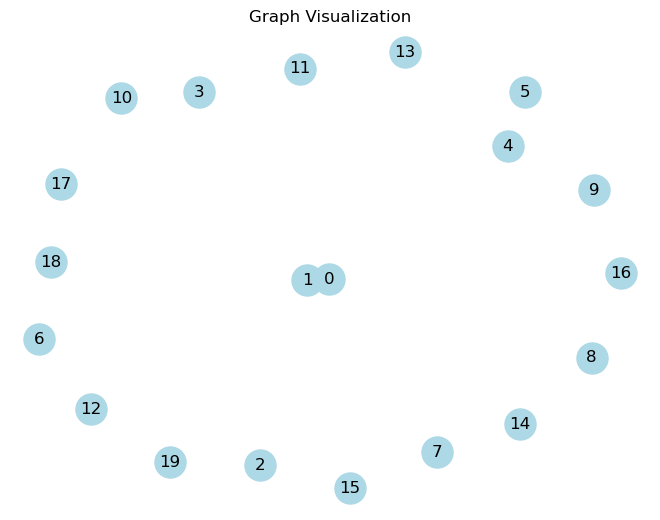

In [29]:
visualize_graph(graphs[3])

In [30]:
!pip install torch_geometric

In [31]:
import networkx as nx
import torch
import numpy as np
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx

In [32]:
import torch

# Example graph object from the user's data
graph = graphs[3]

# Extracting edge indices
edge_indices = graph.edge_index.t().tolist()

# Extracting node features (assuming each node has a feature vector)
node_features = graph.x.tolist()

# The nodes can be represented as a list of indices from 0 to the number of nodes - 1
node_indices = list(range(len(node_features)))

# Displaying the node indices and edge indices
#node_indices, edge_indices
#print(node_features)

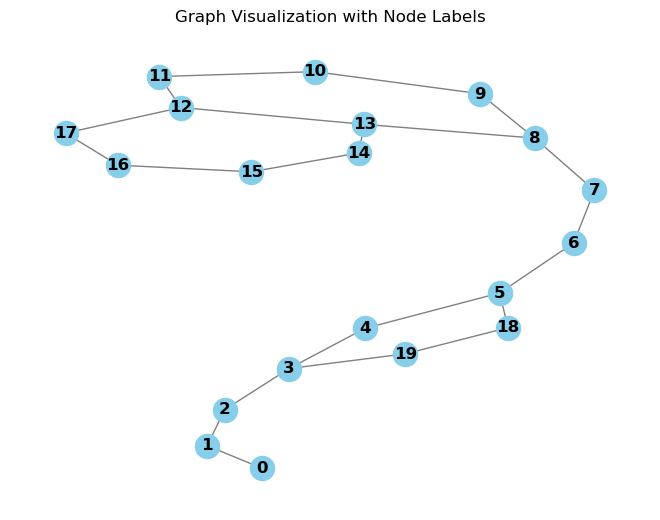

In [33]:
import networkx as nx
import torch_geometric

edge_index = torch.tensor(edge_indices, dtype=torch.long)
x = torch.tensor(node_indices, dtype=torch.float)

data = torch_geometric.data.Data(x=x, edge_index=edge_index)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Draw the graph with node labels
pos = nx.spring_layout(g)  # Compute layout
nx.draw(g, pos, with_labels=True, font_weight='bold', node_color='skyblue', edge_color='gray')
plt.title("Graph Visualization with Node Labels")
plt.show()

In [34]:
# Print the edge indices
print(graphs[3].edge_index.t().tolist())

[[0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 5, 18, 18, 19, 19, 3, 13, 8, 17, 12], [1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18, 5, 19, 18, 3, 19, 8, 13, 12, 17]]


In [35]:
# graphs[0] is a torch_geometric.data.Data object from your graphs list
graph = graphs[3]

# Print node features
print("Len of graph:", len(graph))
print("Node Features:")
print(len(graph.x))
#for i, node_feature in enumerate(graph.x):
    #print(f"Node {i}: {node_feature}")

# Print edge pairs and edge features
print("\nEdge Pairs and Features:")
print(graph.edge_index.t())
for i, edge in enumerate(graph.edge_index.t()):
    src, dest = edge[0].item(), edge[1].item()
    edge_feature = graph.edge_attr[i]
    #print(f"Edge {i} - Source: {src}, Destination: {dest}, Features: {edge_feature}")


Len of graph: 3
Node Features:
20

Edge Pairs and Features:
tensor([[ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17,  5, 18,
         18, 19, 19,  3, 13,  8, 17, 12],
        [ 1,  0,  2,  1,  3,  2,  4,  3,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 11, 13, 12, 14, 13, 15, 14, 16, 15, 17, 16, 18,  5,
         19, 18,  3, 19,  8, 13, 12, 17]])


In [36]:
# Extracting edge list and edge features from the provided graph
graph = graphs[5]  

# Extracting edge index
edge_index = graph.edge_index.t()

# Preparing the edge list
edge_list = []
for i in range(edge_index.shape[1]):
    edge = edge_index[:, i]
    edge_list.append((edge[0].item(), edge[1].item()))

edge_list


[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (7, 9),
 (9, 7),
 (9, 10),
 (10, 9),
 (1, 11),
 (11, 1),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (17, 18),
 (18, 17),
 (18, 19),
 (19, 18),
 (19, 20),
 (20, 19),
 (20, 21),
 (21, 20),
 (21, 22),
 (22, 21),
 (22, 23),
 (23, 22),
 (14, 24),
 (24, 14),
 (24, 25),
 (25, 24),
 (10, 4),
 (4, 10),
 (25, 11),
 (11, 25),
 (23, 15),
 (15, 23),
 (23, 18),
 (18, 23)]

In [37]:
import torch
from torch_geometric.data import Data

# Assuming graph_data is your list of graph objects
# graph_data[0] is the first graph object

# Select the first graph object
first_graph = graphs[3]

# Convert node features to a floating-point type if they aren't already
node_features_float = first_graph.x.float()

# Inspect node features
print("Node features (x) of the first graph:")
print(node_features_float)
print("Shape of node features:", node_features_float.shape)

# Inspect edge features
print("\nEdge features (edge_attr) of the first graph:")
print(first_graph.edge_attr)
print("Shape of edge features:", first_graph.edge_attr.shape)

# Inspect edge index (connectivity)
print("\nEdge index (edge_index) of the first graph:")
print(first_graph.edge_index)
print("Shape of edge index:", first_graph.edge_index.shape)

# Calculate min and max for each node feature of the first graph
min_values, max_values = node_features_float.min(dim=0)[0], node_features_float.max(dim=0)[0]

print("\nMinimum values of node features:", min_values)
print("Maximum values of node features:", max_values)

# Calculate the standard deviation for each node feature
std_deviation = node_features_float.std(dim=0)
print("\nStandard deviation of node features:", std_deviation)


Node features (x) of the first graph:
tensor([[ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000, -0.3944],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0628],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0658],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0275],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.1335],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0670]])
Shape of node features: torch.Size([20, 72])

Edge features (edge_attr) of the first graph:
tensor([[1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 1.,

In [38]:
smiles_df['SMILES'][3]

'OCCn1cc(CNc2cccc3c2CCCC3)nn1'

In [39]:
mol = Chem.MolFromSmiles(smiles_df['SMILES'][3])
AllChem.ComputeGasteigerCharges(mol)

In [40]:
edge_indices = []
for bond in mol.GetBonds():
    start_idx = bond.GetBeginAtomIdx()
    end_idx = bond.GetEndAtomIdx()
    edge_indices.append((start_idx, end_idx))
    edge_indices.append((end_idx, start_idx))  # Add the reverse direction


In [41]:
edge_indices

[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (4, 5),
 (5, 4),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (11, 10),
 (11, 12),
 (12, 11),
 (12, 13),
 (13, 12),
 (13, 14),
 (14, 13),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (5, 18),
 (18, 5),
 (18, 19),
 (19, 18),
 (19, 3),
 (3, 19),
 (13, 8),
 (8, 13),
 (17, 12),
 (12, 17)]

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch.nn import Linear

In [43]:
print((graphs[0]))
print((smiles_df.head(1)))

Data(x=[25, 72], edge_index=[54, 2], edge_attr=[54, 10])
                                   SMILES
0  CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1


In [44]:
print(len(graphs))
print(len(smiles_df))

402
402


In [45]:
# Check lengths after removal
print("Length of smiles_df:", len(smiles_df))


Length of smiles_df: 402


In [46]:
smiles_df.head(5)

,SMILES
0,CN(c1ccccc1)c1ccccc1C(=O)NCC1(O)CCOCC1
1,CC[NH+](CC)C1CCC([NH2+]C2CC2)(C(=O)[O-])C1
2,COCC(CNC(=O)c1ccc2c(c1)NC(=O)C2)OC
3,OCCn1cc(CNc2cccc3c2CCCC3)nn1
4,CCCCCCc1ccc(C#Cc2ccc(C#CC3=CC=C(CCC)CC3)c(C3CC...


In [47]:
print(type(graphs[3]))

<class 'torch_geometric.data.data.Data'>


In [48]:
# Unsupervised Graph Generative Adversarial Netwrok

In [49]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv

In [50]:
def generate_random_edge_index(num_nodes):
    # Example implementation to generate a random edge_index
    # Here we create a fully connected graph for simplicity
    edge_index = torch.combinations(torch.arange(num_nodes), r=2)
    return torch.cat([edge_index, edge_index.flip([1])], dim=0).t()  # Making it undirected

In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Data, Batch
from torch_geometric.utils import erdos_renyi_graph

def generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes):
    """
    Generate random noise for a batch of graphs with variable number of nodes and edges,
    but fixed node feature and edge feature dimensions.

    Args:
    - batch_size (int): Number of random graphs to generate.
    - node_feature_dim (int): Number of features for each node.
    - edge_feature_dim (int): Number of features for each edge.
    - max_num_nodes (int): Maximum number of nodes a graph can have.

    Returns:
    - A list of Data objects containing random noise for node and edge features.
    """
    random_graphs = []

    for _ in range(batch_size):
        # Randomly determine the number of nodes for this graph
        num_nodes = torch.randint(low=1, high=max_num_nodes, size=(1,)).item()

        # Generate random node features
        x = torch.randn(num_nodes, node_feature_dim)

        # Generate a random graph structure (edge_index)
        edge_index = erdos_renyi_graph(num_nodes, edge_prob=0.5)  # p is the probability of an edge

        # Generate random edge features (if needed)
        num_edges = edge_index.size(1)
        edge_attr = torch.randn(num_edges, edge_feature_dim) if edge_feature_dim > 0 else None

        # Create a Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        random_graphs.append(data)

    #return random_graphs
    return Batch.from_data_list(random_graphs)





In [52]:
# Example usage
batch_size = 32
node_feature_dim = 72  # Number of node features
edge_feature_dim = 10  # Number of edge features, adjust as needed
max_num_nodes = 50    # Maximum number of nodes in a graph

random_noise_graphs = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)

In [53]:
random_noise_graphs 

DataBatch(x=[796, 72], edge_index=[2, 12692], edge_attr=[12692, 10], batch=[796], ptr=[33])

In [54]:
# Generator Model
class Generator_v1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index gen",type(x), type(edge_index))
        #print("x, edge_index gen",x.size(), edge_index.size())
        #print("x, edge_index gen",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("Generator x layer 1:",x)
        x = torch.sigmoid(self.layer2(x, edge_index))
        #print("Generator x  layer 2:",x)
        return x

In [55]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("input_dim")
        self.layer2 = GCNConv(hidden_dim, output_dim)    

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.layer1(x, edge_index))
        x = torch.sigmoid(self.layer2(x, edge_index))

        # Generate fake edge_index (simple example, should be improved)
        fake_edge_index = self.generate_fake_edge_index(x.size(0))
        return x, fake_edge_index

    def generate_fake_edge_index(self, num_nodes):
        # Implement logic to generate a plausible edge_index for fake graphs
        # Placeholder logic: create a simple linear chain graph
        edge_index = torch.tensor([[i, i+1] for i in range(num_nodes - 1)], dtype=torch.long).t()
        return edge_index


In [56]:
# Discriminator Model  
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        #print("In discriminator")
        self.layer1 = GCNConv(input_dim, hidden_dim)
        #print("self.layer1",input_dim,hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, 1)
        #print("self.layer2",hidden_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        #print("x, edge_index1",type(x), type(edge_index))
        #print("x, edge_index2",x.size(), edge_index.size())
        #print("x, edge_index3",x, edge_index)
        x = torch.relu(self.layer1(x, edge_index))
        #print("x 2",x)
        x = torch.sigmoid(self.layer2(x))
        #print("x 3",x)
        return x

In [57]:
# Model Initialization
generator_input_dim = 72
generator_hidden_dim = 256
#generator_hidden_dim = 128
generator_output_dim = 72

discriminator_input_dim = 72
discriminator_hidden_dim = 256
#discriminator_hidden_dim = 128

In [58]:
generator = Generator(generator_input_dim, generator_hidden_dim, generator_output_dim)
discriminator = Discriminator(discriminator_input_dim, discriminator_hidden_dim)

In [59]:
import torch.optim as optim
from torch_geometric.data import DataLoader
#from torch_geometric.loader import DataLoader

from torch.utils.data import Dataset

# Sample data loader (replace with your dataset)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True)
#data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=['x', 'edge_index'])
data_loader = DataLoader(graphs, batch_size=32, shuffle=True, follow_batch=[])



# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Loss function
adversarial_loss = torch.nn.BCELoss()

C:\Users\Malli\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [60]:
# Function to calculate discriminator accuracy
def calculate_discriminator_accuracy(discriminator, real_data, fake_data):
    real_predictions = discriminator(real_data).round()
    fake_predictions = discriminator(fake_data).round()
    correct_predictions = (real_predictions == 1).sum() + (fake_predictions == 0).sum()
    total_predictions = real_predictions.numel() + fake_predictions.numel()
    accuracy = 100 * correct_predictions.float() / total_predictions
    return accuracy

In [61]:
print((data_loader))

In [62]:
print((graphs[3].x).shape)
print((graphs[3].edge_index).shape)

torch.Size([20, 72])
torch.Size([44, 2])


In [63]:
print((graphs[0].x).shape)
print((graphs[0].edge_index).shape)

torch.Size([25, 72])
torch.Size([54, 2])


In [64]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch

def custom_graph_data_loader(graph_dataset, batch_size):
    """
    Custom data loader for graph data.
    
    Args:
    - graph_dataset (list of Data): The dataset containing graph Data objects.
    - batch_size (int): The size of each batch.

    Yields:
    - Batched Data object containing a batch of graphs.
    """

    def batch_graphs(graphs):
        """
        Manually batches a list of graphs into a single Batch object.
        """
        batched_edge_index = []
        batched_x = []
        batched_batch = []

        current_node_idx = 0
        for i, graph in enumerate(graphs):
            # Offset the node indices by the current_node_idx and add them to the batched edge index.
            #edge_index_offset = graph.edge_index + current_node_idx
            #batched_edge_index.append(edge_index_offset)
            
            # Offset only the node indices in the edge_index tensor.
            edge_index_offset = graph.edge_index.clone()  # Make a copy to avoid modifying the original graph
            edge_index_offset[0, :] += current_node_idx  # Offset source node indices
            edge_index_offset[1, :] += current_node_idx  # Offset target node indices
            #batched_edge_index.append(edge_index_offset)            
            
            #Tring edge_index
            #batched_edge_index.append(graph.edge_index)
            batched_edge_index.append(graph.edge_index + current_node_idx)

            # Add the current graph's node features to the batched node features.
            batched_x.append(graph.x)

            # Add the graph index to the batch vector for all nodes of this graph.
            batched_batch.append(torch.full((graph.x.size(0),), i, dtype=torch.long))

            # Update the current_node_idx for the next graph.
            current_node_idx += graph.x.size(0)

        # Concatenate all the lists to create tensors.       
        
        batched_edge_index = torch.cat(batched_edge_index, dim=0)
        batched_x = torch.cat(batched_x, dim=0)
        batched_batch = torch.cat(batched_batch, dim=0)
        

        # Create a new Data object to hold the batched graph.
        batched_data = Data(x=batched_x, edge_index=batched_edge_index)
        batched_data.batch = batched_batch

        return batched_data

    # Shuffle dataset at the beginning of each epoch
    indices = torch.randperm(len(graph_dataset))
    
    for start in range(0, len(indices), batch_size):
        end = start + batch_size
        batch_indices = indices[start:end]
        batch_graphs_list = [graph_dataset[i] for i in batch_indices]
        batch = batch_graphs(batch_graphs_list)
        yield batch


In [65]:
import matplotlib.pyplot as plt
import torch

def calculate_accuracy(preds, labels):
    predicted_labels = preds.round()  # Convert probabilities to 0/1
    correct = (predicted_labels == labels).float()  # Convert into float for division 
    accuracy = correct.sum() / len(correct)
    return accuracy

In [66]:
num_epochs = 100
batch_size = 32

# Lists to store metrics
epochs = []
d_losses = []
g_losses = []
real_accuracy_list =[]
fake_accuracy_list=[]
d_accuracies = []


for epoch in range(num_epochs):
    print("epoch", epoch)
    for batch in custom_graph_data_loader(graphs, batch_size):
        # Generate fake data
        random_noise_graphs_batch = generate_random_noise(batch_size, node_feature_dim, edge_feature_dim, max_num_nodes)
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)

        # Ensure the real edge_index is correctly shaped [2, num_edges]
        if batch.edge_index.size(0) != 2:
            batch.edge_index = batch.edge_index.t()  # Transpose if necessary        
        
        # Create fake data batch with both x and edge_index
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)

        # Labels for real and fake data (for each node)
        real_labels = torch.ones(batch.x.size(0), 1)
        fake_labels = torch.zeros(fake_data.x.size(0), 1)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(batch), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_data), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        # Recompute fake data and perform forward pass through discriminator
        fake_x, fake_edge_index = generator(random_noise_graphs_batch)
        fake_data = Data(x=fake_x, edge_index=fake_edge_index)
        updated_real_labels = torch.ones(fake_data.x.size(0), 1)
        g_loss = adversarial_loss(discriminator(fake_data), updated_real_labels)
        g_loss.backward()
        optimizer_G.step()
        
        
        # Calculate discriminator accuracy
        real_accuracy = calculate_accuracy(discriminator(batch).detach(), real_labels)
        print("real_accuracy",real_accuracy)
        fake_accuracy = calculate_accuracy(discriminator(fake_data).detach(), fake_labels)
        print("fake_accuracy",fake_accuracy)
        d_accuracy = (real_accuracy + fake_accuracy) / 2

        # Store metrics
        d_losses.append(d_loss.item())
        print("d_loss.item()",d_loss.item())
        g_losses.append(g_loss.item())
        print("g_loss.item()",g_loss.item())
        d_accuracies.append(d_accuracy.item())
        real_accuracy_list.append(real_accuracy.item())
        fake_accuracy_list.append(fake_accuracy.item())
        
        epochs.append(epoch)


epoch 0
real_accuracy tensor(0.3474)
fake_accuracy tensor(1.)
d_loss.item() 1.4037787914276123
g_loss.item() 0.7705609202384949
real_accuracy tensor(0.2602)
fake_accuracy tensor(1.)
d_loss.item() 1.333050012588501
g_loss.item() 0.8536769151687622
real_accuracy tensor(0.3012)
fake_accuracy tensor(1.)
d_loss.item() 1.2628748416900635
g_loss.item() 0.9430147409439087
real_accuracy tensor(0.3699)
fake_accuracy tensor(1.)
d_loss.item() 1.197396993637085
g_loss.item() 1.034121036529541
real_accuracy tensor(0.3989)
fake_accuracy tensor(1.)
d_loss.item() 1.1448471546173096
g_loss.item() 1.124459147453308
real_accuracy tensor(0.4516)
fake_accuracy tensor(1.)
d_loss.item() 1.0908781290054321
g_loss.item() 1.2225911617279053
real_accuracy tensor(0.5843)
fake_accuracy tensor(1.)
d_loss.item() 1.044721007347107
g_loss.item() 1.3192135095596313
real_accuracy tensor(0.6566)
fake_accuracy tensor(1.)
d_loss.item() 1.0002617835998535
g_loss.item() 1.4217101335525513
real_accuracy tensor(0.8076)
fake_acc

real_accuracy tensor(1.)
fake_accuracy tensor(0.8764)
d_loss.item() 0.5953681468963623
g_loss.item() 1.7515696287155151
real_accuracy tensor(1.)
fake_accuracy tensor(0.9174)
d_loss.item() 0.5445861220359802
g_loss.item() 1.7715181112289429
real_accuracy tensor(1.)
fake_accuracy tensor(0.8907)
d_loss.item() 0.5700968503952026
g_loss.item() 1.837852120399475
real_accuracy tensor(1.)
fake_accuracy tensor(0.9271)
d_loss.item() 0.5147926807403564
g_loss.item() 2.153524160385132
real_accuracy tensor(0.9988)
fake_accuracy tensor(0.8920)
d_loss.item() 0.5907410383224487
g_loss.item() 1.9557050466537476
real_accuracy tensor(0.9964)
fake_accuracy tensor(0.9743)
d_loss.item() 0.5387526154518127
g_loss.item() 2.012845039367676
real_accuracy tensor(1.)
fake_accuracy tensor(0.9224)
d_loss.item() 0.5797632932662964
g_loss.item() 1.9930497407913208
real_accuracy tensor(0.9893)
fake_accuracy tensor(0.9253)
d_loss.item() 0.6315798163414001
g_loss.item() 2.079118490219116
real_accuracy tensor(0.9829)
fak

real_accuracy tensor(0.4507)
fake_accuracy tensor(0.5135)
d_loss.item() 1.6166677474975586
g_loss.item() 0.6933099627494812
real_accuracy tensor(0.4203)
fake_accuracy tensor(0.4975)
d_loss.item() 1.7247138023376465
g_loss.item() 0.6857923865318298
real_accuracy tensor(0.6574)
fake_accuracy tensor(0.4832)
d_loss.item() 1.4534342288970947
g_loss.item() 0.6902318596839905
epoch 11
real_accuracy tensor(0.5424)
fake_accuracy tensor(0.3621)
d_loss.item() 1.6204123497009277
g_loss.item() 0.6594330072402954
real_accuracy tensor(0.3957)
fake_accuracy tensor(0.4147)
d_loss.item() 1.7717862129211426
g_loss.item() 0.6665753722190857
real_accuracy tensor(0.4629)
fake_accuracy tensor(0.4761)
d_loss.item() 1.695265769958496
g_loss.item() 0.7012101411819458
real_accuracy tensor(0.4293)
fake_accuracy tensor(0.5595)
d_loss.item() 1.6806261539459229
g_loss.item() 0.7261951565742493
real_accuracy tensor(0.4195)
fake_accuracy tensor(0.6314)
d_loss.item() 1.6662107706069946
g_loss.item() 0.7342308163642883


real_accuracy tensor(0.8804)
fake_accuracy tensor(1.)
d_loss.item() 0.6919994354248047
g_loss.item() 1.451982855796814
real_accuracy tensor(0.9072)
fake_accuracy tensor(1.)
d_loss.item() 0.6881642937660217
g_loss.item() 1.4394557476043701
real_accuracy tensor(0.8821)
fake_accuracy tensor(1.)
d_loss.item() 0.6966125965118408
g_loss.item() 1.4580796957015991
real_accuracy tensor(0.8855)
fake_accuracy tensor(1.)
d_loss.item() 0.6958093047142029
g_loss.item() 1.4451394081115723
real_accuracy tensor(0.8766)
fake_accuracy tensor(1.)
d_loss.item() 0.7081391215324402
g_loss.item() 1.4534684419631958
real_accuracy tensor(0.9180)
fake_accuracy tensor(1.)
d_loss.item() 0.6819597482681274
g_loss.item() 1.4163349866867065
real_accuracy tensor(0.9128)
fake_accuracy tensor(1.)
d_loss.item() 0.6879093647003174
g_loss.item() 1.428006887435913
real_accuracy tensor(0.8977)
fake_accuracy tensor(1.)
d_loss.item() 0.6568093299865723
g_loss.item() 1.4751958847045898
real_accuracy tensor(0.8906)
fake_accuracy

fake_accuracy tensor(1.)
d_loss.item() 0.5080879926681519
g_loss.item() 1.5450080633163452
real_accuracy tensor(0.9066)
fake_accuracy tensor(1.)
d_loss.item() 0.5464462041854858
g_loss.item() 1.4464595317840576
real_accuracy tensor(0.9142)
fake_accuracy tensor(1.)
d_loss.item() 0.6207080483436584
g_loss.item() 1.3002045154571533
real_accuracy tensor(0.9132)
fake_accuracy tensor(0.9976)
d_loss.item() 0.674854040145874
g_loss.item() 1.2264721393585205
real_accuracy tensor(0.8617)
fake_accuracy tensor(1.)
d_loss.item() 0.8082671165466309
g_loss.item() 1.1321929693222046
real_accuracy tensor(0.8925)
fake_accuracy tensor(0.9726)
d_loss.item() 0.8182487487792969
g_loss.item() 1.0877313613891602
real_accuracy tensor(0.9040)
fake_accuracy tensor(0.9340)
d_loss.item() 0.8954761028289795
g_loss.item() 1.0053420066833496
real_accuracy tensor(0.8634)
fake_accuracy tensor(0.9357)
d_loss.item() 0.9938636422157288
g_loss.item() 0.9603157639503479
real_accuracy tensor(0.8561)
fake_accuracy tensor(0.97

real_accuracy tensor(0.9443)
fake_accuracy tensor(1.)
d_loss.item() 0.49059849977493286
g_loss.item() 1.668690800666809
real_accuracy tensor(0.9450)
fake_accuracy tensor(1.)
d_loss.item() 0.48157358169555664
g_loss.item() 1.6684616804122925
real_accuracy tensor(0.9233)
fake_accuracy tensor(1.)
d_loss.item() 0.5277690291404724
g_loss.item() 1.6342051029205322
real_accuracy tensor(0.9410)
fake_accuracy tensor(1.)
d_loss.item() 0.4972660541534424
g_loss.item() 1.659591555595398
real_accuracy tensor(0.9258)
fake_accuracy tensor(1.)
d_loss.item() 0.5254991054534912
g_loss.item() 1.6939483880996704
real_accuracy tensor(0.8527)
fake_accuracy tensor(1.)
d_loss.item() 0.5871284604072571
g_loss.item() 1.723031997680664
epoch 27
real_accuracy tensor(0.8651)
fake_accuracy tensor(1.)
d_loss.item() 0.5661569833755493
g_loss.item() 1.7138804197311401
real_accuracy tensor(0.8483)
fake_accuracy tensor(1.)
d_loss.item() 0.598170280456543
g_loss.item() 1.7255443334579468
real_accuracy tensor(0.8546)
fake

real_accuracy tensor(0.9524)
fake_accuracy tensor(1.)
d_loss.item() 0.20305459201335907
g_loss.item() 2.7515032291412354
epoch 32
real_accuracy tensor(0.9587)
fake_accuracy tensor(1.)
d_loss.item() 0.201199471950531
g_loss.item() 2.7571935653686523
real_accuracy tensor(0.9444)
fake_accuracy tensor(1.)
d_loss.item() 0.21322688460350037
g_loss.item() 2.7781424522399902
real_accuracy tensor(0.9545)
fake_accuracy tensor(1.)
d_loss.item() 0.22088412940502167
g_loss.item() 2.654343843460083
real_accuracy tensor(0.9638)
fake_accuracy tensor(1.)
d_loss.item() 0.2139037847518921
g_loss.item() 2.687041759490967
real_accuracy tensor(0.9377)
fake_accuracy tensor(1.)
d_loss.item() 0.24917256832122803
g_loss.item() 2.6933772563934326
real_accuracy tensor(0.9596)
fake_accuracy tensor(1.)
d_loss.item() 0.2587473392486572
g_loss.item() 2.4856574535369873
real_accuracy tensor(0.9486)
fake_accuracy tensor(1.)
d_loss.item() 0.3106311857700348
g_loss.item() 2.327326536178589
real_accuracy tensor(0.9330)
fa

real_accuracy tensor(0.9696)
fake_accuracy tensor(1.)
d_loss.item() 0.11033176630735397
g_loss.item() 3.9499690532684326
real_accuracy tensor(0.9695)
fake_accuracy tensor(1.)
d_loss.item() 0.10047093033790588
g_loss.item() 3.8022992610931396
real_accuracy tensor(0.9692)
fake_accuracy tensor(1.)
d_loss.item() 0.11766403913497925
g_loss.item() 3.5395209789276123
real_accuracy tensor(0.9646)
fake_accuracy tensor(1.)
d_loss.item() 0.11930312216281891
g_loss.item() 3.446234941482544
real_accuracy tensor(0.9512)
fake_accuracy tensor(1.)
d_loss.item() 0.16110318899154663
g_loss.item() 3.2446892261505127
real_accuracy tensor(0.9629)
fake_accuracy tensor(1.)
d_loss.item() 0.14373348653316498
g_loss.item() 3.2156150341033936
real_accuracy tensor(0.9671)
fake_accuracy tensor(1.)
d_loss.item() 0.14842236042022705
g_loss.item() 3.1046526432037354
real_accuracy tensor(0.9692)
fake_accuracy tensor(1.)
d_loss.item() 0.14174556732177734
g_loss.item() 3.1092469692230225
real_accuracy tensor(0.9616)
fake

real_accuracy tensor(0.9627)
fake_accuracy tensor(1.)
d_loss.item() 0.09574239701032639
g_loss.item() 4.540014743804932
real_accuracy tensor(0.9728)
fake_accuracy tensor(1.)
d_loss.item() 0.0937192365527153
g_loss.item() 4.631368637084961
real_accuracy tensor(0.9775)
fake_accuracy tensor(1.)
d_loss.item() 0.07121674716472626
g_loss.item() 4.761873245239258
real_accuracy tensor(0.9434)
fake_accuracy tensor(1.)
d_loss.item() 0.11680418252944946
g_loss.item() 4.9199934005737305
real_accuracy tensor(0.9631)
fake_accuracy tensor(1.)
d_loss.item() 0.09949695318937302
g_loss.item() 4.959183216094971
epoch 43
real_accuracy tensor(0.9729)
fake_accuracy tensor(1.)
d_loss.item() 0.07790025323629379
g_loss.item() 5.047137260437012
real_accuracy tensor(0.9755)
fake_accuracy tensor(1.)
d_loss.item() 0.07875990867614746
g_loss.item() 5.0777058601379395
real_accuracy tensor(0.9691)
fake_accuracy tensor(1.)
d_loss.item() 0.07862234115600586
g_loss.item() 5.113188743591309
real_accuracy tensor(0.9837)
f

real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.04174301028251648
g_loss.item() 4.062193393707275
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.04319845139980316
g_loss.item() 3.9571681022644043
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.04521084576845169
g_loss.item() 3.9377951622009277
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.03903018683195114
g_loss.item() 3.8918654918670654
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.051424283534288406
g_loss.item() 3.6927521228790283
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.05579126626253128
g_loss.item() 3.5810935497283936
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.056998781859874725
g_loss.item() 3.4114110469818115
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.06288360059261322
g_loss.item() 3.2841036319732666
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item()

real_accuracy tensor(0.9435)
fake_accuracy tensor(1.)
d_loss.item() 0.25751638412475586
g_loss.item() 2.2361502647399902
real_accuracy tensor(0.9351)
fake_accuracy tensor(1.)
d_loss.item() 0.25880447030067444
g_loss.item() 2.27712082862854
real_accuracy tensor(0.9653)
fake_accuracy tensor(1.)
d_loss.item() 0.2105870544910431
g_loss.item() 2.2821874618530273
real_accuracy tensor(0.9440)
fake_accuracy tensor(1.)
d_loss.item() 0.24461020529270172
g_loss.item() 2.2612802982330322
real_accuracy tensor(0.9633)
fake_accuracy tensor(1.)
d_loss.item() 0.22240425646305084
g_loss.item() 2.2496399879455566
real_accuracy tensor(0.9481)
fake_accuracy tensor(1.)
d_loss.item() 0.23759815096855164
g_loss.item() 2.303725242614746
real_accuracy tensor(0.9455)
fake_accuracy tensor(1.)
d_loss.item() 0.2380531281232834
g_loss.item() 2.314013957977295
epoch 54
real_accuracy tensor(0.9612)
fake_accuracy tensor(1.)
d_loss.item() 0.22275972366333008
g_loss.item() 2.293003797531128
real_accuracy tensor(0.9397)
f

real_accuracy tensor(0.9782)
fake_accuracy tensor(1.)
d_loss.item() 0.12136922776699066
g_loss.item() 3.6639583110809326
real_accuracy tensor(0.9879)
fake_accuracy tensor(1.)
d_loss.item() 0.09959214925765991
g_loss.item() 3.608731508255005
epoch 59
real_accuracy tensor(0.9644)
fake_accuracy tensor(1.)
d_loss.item() 0.13556130230426788
g_loss.item() 3.645169496536255
real_accuracy tensor(0.9606)
fake_accuracy tensor(1.)
d_loss.item() 0.15348497033119202
g_loss.item() 3.679626703262329
real_accuracy tensor(0.9594)
fake_accuracy tensor(1.)
d_loss.item() 0.14643853902816772
g_loss.item() 3.579925060272217
real_accuracy tensor(0.9822)
fake_accuracy tensor(1.)
d_loss.item() 0.10641486942768097
g_loss.item() 3.580284595489502
real_accuracy tensor(0.9823)
fake_accuracy tensor(1.)
d_loss.item() 0.11848213523626328
g_loss.item() 3.5868165493011475
real_accuracy tensor(0.9880)
fake_accuracy tensor(1.)
d_loss.item() 0.11066845059394836
g_loss.item() 3.5347843170166016
real_accuracy tensor(0.9732)

real_accuracy tensor(0.9807)
fake_accuracy tensor(1.)
d_loss.item() 0.14273500442504883
g_loss.item() 3.9752120971679688
real_accuracy tensor(0.9787)
fake_accuracy tensor(1.)
d_loss.item() 0.11882342398166656
g_loss.item() 3.929701566696167
real_accuracy tensor(0.9852)
fake_accuracy tensor(1.)
d_loss.item() 0.10325396806001663
g_loss.item() 3.9715964794158936
real_accuracy tensor(0.9842)
fake_accuracy tensor(1.)
d_loss.item() 0.09954182803630829
g_loss.item() 3.952282667160034
real_accuracy tensor(0.9806)
fake_accuracy tensor(1.)
d_loss.item() 0.1305677443742752
g_loss.item() 3.9338135719299316
real_accuracy tensor(0.9890)
fake_accuracy tensor(1.)
d_loss.item() 0.08781877160072327
g_loss.item() 3.9281349182128906
real_accuracy tensor(0.9796)
fake_accuracy tensor(1.)
d_loss.item() 0.09710270911455154
g_loss.item() 3.906972885131836
real_accuracy tensor(0.9917)
fake_accuracy tensor(1.)
d_loss.item() 0.08318771421909332
g_loss.item() 3.8926916122436523
real_accuracy tensor(0.9918)
fake_ac

real_accuracy tensor(0.9906)
fake_accuracy tensor(1.)
d_loss.item() 0.07118681818246841
g_loss.item() 4.282221794128418
real_accuracy tensor(0.9908)
fake_accuracy tensor(1.)
d_loss.item() 0.07300249487161636
g_loss.item() 4.214125633239746
real_accuracy tensor(0.9925)
fake_accuracy tensor(1.)
d_loss.item() 0.06561632454395294
g_loss.item() 4.214881896972656
real_accuracy tensor(0.9908)
fake_accuracy tensor(1.)
d_loss.item() 0.06981389224529266
g_loss.item() 4.193856239318848
real_accuracy tensor(0.9979)
fake_accuracy tensor(1.)
d_loss.item() 0.06376625597476959
g_loss.item() 4.1772074699401855
real_accuracy tensor(0.9915)
fake_accuracy tensor(1.)
d_loss.item() 0.06858557462692261
g_loss.item() 4.143478870391846
real_accuracy tensor(0.9900)
fake_accuracy tensor(1.)
d_loss.item() 0.07347317039966583
g_loss.item() 4.159999847412109
real_accuracy tensor(0.9909)
fake_accuracy tensor(1.)
d_loss.item() 0.06154758483171463
g_loss.item() 4.091483116149902
epoch 70
real_accuracy tensor(0.9799)
f

real_accuracy tensor(0.8965)
fake_accuracy tensor(1.)
d_loss.item() 0.2567647695541382
g_loss.item() 3.2876734733581543
real_accuracy tensor(0.9201)
fake_accuracy tensor(1.)
d_loss.item() 0.23338912427425385
g_loss.item() 3.2867047786712646
real_accuracy tensor(0.8910)
fake_accuracy tensor(1.)
d_loss.item() 0.2661944031715393
g_loss.item() 3.4404706954956055
real_accuracy tensor(0.9109)
fake_accuracy tensor(1.)
d_loss.item() 0.24612528085708618
g_loss.item() 3.2458200454711914
real_accuracy tensor(0.8952)
fake_accuracy tensor(1.)
d_loss.item() 0.26658767461776733
g_loss.item() 3.335569143295288
epoch 75
real_accuracy tensor(0.9402)
fake_accuracy tensor(1.)
d_loss.item() 0.22862091660499573
g_loss.item() 3.163261651992798
real_accuracy tensor(0.9292)
fake_accuracy tensor(1.)
d_loss.item() 0.21213650703430176
g_loss.item() 3.1403937339782715
real_accuracy tensor(0.9410)
fake_accuracy tensor(1.)
d_loss.item() 0.2205585390329361
g_loss.item() 3.118656635284424
real_accuracy tensor(0.9368)


real_accuracy tensor(0.9359)
fake_accuracy tensor(1.)
d_loss.item() 0.24729597568511963
g_loss.item() 2.5113935470581055
real_accuracy tensor(0.9293)
fake_accuracy tensor(1.)
d_loss.item() 0.2731732726097107
g_loss.item() 2.487396717071533
real_accuracy tensor(0.9391)
fake_accuracy tensor(1.)
d_loss.item() 0.24169030785560608
g_loss.item() 2.5227577686309814
real_accuracy tensor(0.9429)
fake_accuracy tensor(1.)
d_loss.item() 0.22009098529815674
g_loss.item() 2.5212581157684326
real_accuracy tensor(0.9283)
fake_accuracy tensor(1.)
d_loss.item() 0.24188068509101868
g_loss.item() 2.5554957389831543
real_accuracy tensor(0.9509)
fake_accuracy tensor(1.)
d_loss.item() 0.20779132843017578
g_loss.item() 2.565444231033325
real_accuracy tensor(0.9477)
fake_accuracy tensor(1.)
d_loss.item() 0.210015207529068
g_loss.item() 2.60152530670166
real_accuracy tensor(0.9486)
fake_accuracy tensor(1.)
d_loss.item() 0.20015114545822144
g_loss.item() 2.65236234664917
real_accuracy tensor(0.9562)
fake_accurac

real_accuracy tensor(0.9353)
fake_accuracy tensor(0.5562)
d_loss.item() 1.0190364122390747
g_loss.item() 0.8025219440460205
real_accuracy tensor(0.9139)
fake_accuracy tensor(0.3769)
d_loss.item() 1.2308764457702637
g_loss.item() 0.6558159589767456
real_accuracy tensor(0.8503)
fake_accuracy tensor(0.4535)
d_loss.item() 1.2425247430801392
g_loss.item() 0.7215031385421753
real_accuracy tensor(0.8808)
fake_accuracy tensor(0.6146)
d_loss.item() 1.1251578330993652
g_loss.item() 0.7732627391815186
real_accuracy tensor(0.8799)
fake_accuracy tensor(0.3913)
d_loss.item() 1.2453811168670654
g_loss.item() 0.6654516458511353
real_accuracy tensor(0.8463)
fake_accuracy tensor(0.4480)
d_loss.item() 1.2084970474243164
g_loss.item() 0.7651300430297852
real_accuracy tensor(0.8356)
fake_accuracy tensor(0.7169)
d_loss.item() 1.0920367240905762
g_loss.item() 0.8577128648757935
real_accuracy tensor(0.7987)
fake_accuracy tensor(0.8774)
d_loss.item() 1.1009023189544678
g_loss.item() 0.9143611192703247
real_acc

real_accuracy tensor(0.9616)
fake_accuracy tensor(1.)
d_loss.item() 0.21206891536712646
g_loss.item() 2.8199098110198975
real_accuracy tensor(0.9510)
fake_accuracy tensor(1.)
d_loss.item() 0.21302664279937744
g_loss.item() 2.88020658493042
real_accuracy tensor(0.9572)
fake_accuracy tensor(1.)
d_loss.item() 0.20891055464744568
g_loss.item() 2.8794655799865723
real_accuracy tensor(0.9718)
fake_accuracy tensor(1.)
d_loss.item() 0.18063493072986603
g_loss.item() 2.936129093170166
real_accuracy tensor(0.9709)
fake_accuracy tensor(1.)
d_loss.item() 0.1779569685459137
g_loss.item() 2.9061684608459473
epoch 91
real_accuracy tensor(0.9698)
fake_accuracy tensor(1.)
d_loss.item() 0.16883426904678345
g_loss.item() 3.184079170227051
real_accuracy tensor(0.9644)
fake_accuracy tensor(1.)
d_loss.item() 0.1864580512046814
g_loss.item() 3.1168642044067383
real_accuracy tensor(0.9802)
fake_accuracy tensor(1.)
d_loss.item() 0.16946730017662048
g_loss.item() 3.1585378646850586
real_accuracy tensor(0.9599)


real_accuracy tensor(0.9976)
fake_accuracy tensor(1.)
d_loss.item() 0.08675108850002289
g_loss.item() 3.2530980110168457
real_accuracy tensor(0.9987)
fake_accuracy tensor(1.)
d_loss.item() 0.07671516388654709
g_loss.item() 3.3194804191589355
real_accuracy tensor(0.9972)
fake_accuracy tensor(1.)
d_loss.item() 0.08633115887641907
g_loss.item() 3.145901918411255
real_accuracy tensor(0.9975)
fake_accuracy tensor(1.)
d_loss.item() 0.09367705881595612
g_loss.item() 3.1715168952941895
real_accuracy tensor(0.9990)
fake_accuracy tensor(1.)
d_loss.item() 0.08855360746383667
g_loss.item() 3.2098779678344727
real_accuracy tensor(0.9959)
fake_accuracy tensor(1.)
d_loss.item() 0.09944595396518707
g_loss.item() 3.145986795425415
real_accuracy tensor(0.9949)
fake_accuracy tensor(1.)
d_loss.item() 0.09392747282981873
g_loss.item() 3.066521167755127
real_accuracy tensor(1.)
fake_accuracy tensor(1.)
d_loss.item() 0.09411191940307617
g_loss.item() 3.0097055435180664
real_accuracy tensor(0.9952)
fake_accur

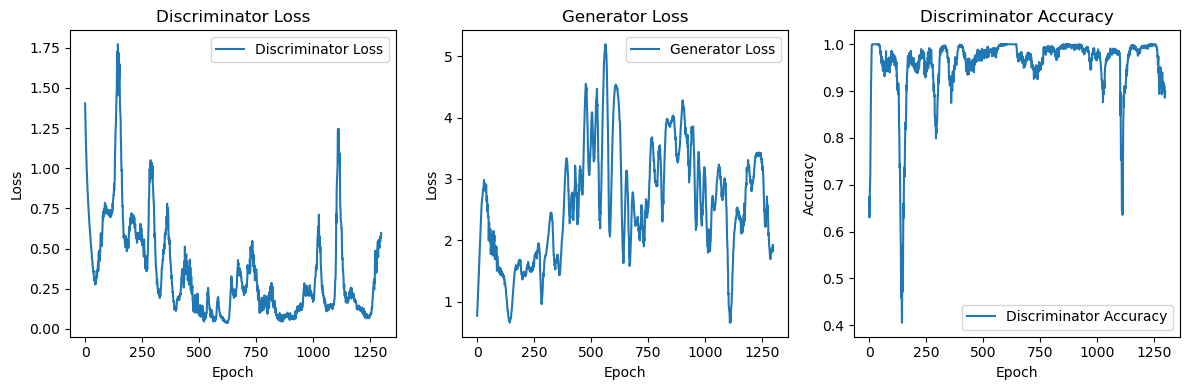

In [67]:
# Plotting
plt.figure(figsize=(12, 4))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(g_losses, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(d_accuracies, label='Discriminator Accuracy')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [68]:
# Platting the values again

In [69]:
# Now we can calculate the averages and plot the values as previously done
# Calculate average values per epoch
avg_real_accuracies = []
avg_fake_accuracies = []
avg_d_losses = []
avg_g_losses = []

In [70]:
# Helper function for averaging
def calculate_average(values):
    return np.mean(values) if values else 0

current_epoch = 0
temp_real_acc = []
temp_fake_acc = []
temp_d_loss = []
temp_g_loss = []

In [71]:
for i in range(len(epochs)):
    if epochs[i] != current_epoch:
        # Calculate averages for the current epoch and reset lists
        avg_real_accuracies.append(calculate_average(temp_real_acc))
        avg_fake_accuracies.append(calculate_average(temp_fake_acc))
        avg_d_losses.append(calculate_average(temp_d_loss))
        avg_g_losses.append(calculate_average(temp_g_loss))

        temp_real_acc = []
        temp_fake_acc = []
        temp_d_loss = []
        temp_g_loss = []
        current_epoch = epochs[i]

    # Append current values
    temp_real_acc.append(real_accuracy_list[i])
    temp_fake_acc.append(fake_accuracy_list[i])
    temp_d_loss.append(d_losses[i])
    temp_g_loss.append(g_losses[i])

In [72]:
# Add averages for the last epoch
avg_real_accuracies.append(calculate_average(temp_real_acc))
avg_fake_accuracies.append(calculate_average(temp_fake_acc))
avg_d_losses.append(calculate_average(temp_d_loss))
avg_g_losses.append(calculate_average(temp_g_loss))

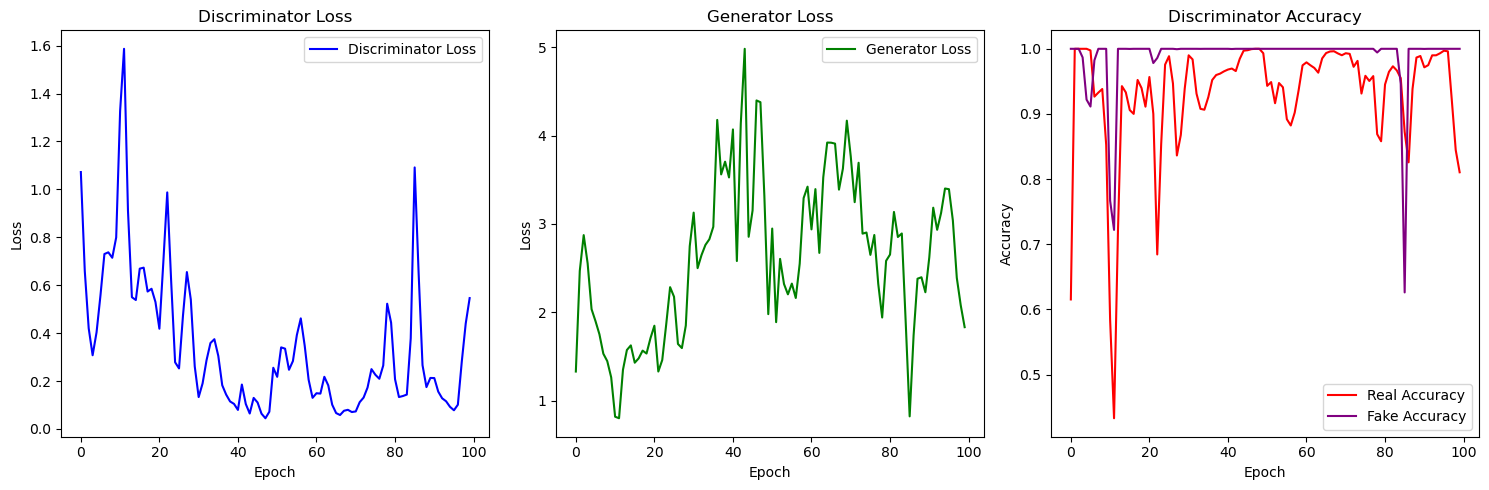

In [73]:
# Unique epochs for plotting
unique_epochs = sorted(list(set(epochs)))

# Plotting the graphs
plt.figure(figsize=(15, 5))

# Plot Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(unique_epochs, avg_d_losses, label='Discriminator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()

# Plot Generator Loss
plt.subplot(1, 3, 2)
plt.plot(unique_epochs, avg_g_losses, label='Generator Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

# Plot Discriminator Accuracy
plt.subplot(1, 3, 3)
plt.plot(unique_epochs, avg_real_accuracies, label='Real Accuracy', color='red')
plt.plot(unique_epochs, avg_fake_accuracies, label='Fake Accuracy', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Discriminator Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
